In [1]:
import os
import random
from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

In [2]:
class cfg:

    seed = 29
    random_state = 29

    epochs = 5
    batch_size = 4

    image_folder = 'image_data/'

In [3]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    train_split, valid_split = {}, {}
    
    # Creating Train-split
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_split[folder] = num_files
    
    # Creating Test-split
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        valid_split[folder] = num_files  

    print(f'Train split: {len(train_split)}, Valid split: {len(valid_split)}')
    return train_split, valid_split

In [4]:
train, valid = split_dataset(cfg.image_folder)

Train split: 1191, Valid split: 133


In [5]:
class Face_dataset(Dataset):

    def __init__(self, img_directory, folder_split):
        self.img_directory = img_directory
        self.folder_split = folder_split
        self.triplets = self.create_triplets()

    def create_triplets(self):
        triplets = []
        folders = list(self.folder_split.keys())

        for folder in folders:
            path = os.path.join(self.img_directory, folder)
            files = list(os.listdir(path))[:10]
            num_files = len(files)

            for i in range(num_files - 1):
                for j in range(i + 1, num_files):
                    anchor = (folder, f"{i}.jpg")
                    positive = (folder, f"{j}.jpg")

                    neg_folder = folder
                    while neg_folder == folder:
                        neg_folder = random.choice(folders)
                    neg_file = random.randint(0, self.folder_split[neg_folder] - 1)
                    negative = (neg_folder, f"{neg_file}.jpg")

                    triplets.append((anchor, positive, negative))
        return triplets

    def __getitem__(self, idx):

        anchor, positive, negative = self.triplets[idx]
        img_path1 = os.path.join(self.img_directory, anchor[0], anchor[1])
        img_path2 = os.path.join(self.img_directory, positive[0], positive[1])
        img_path3 = os.path.join(self.img_directory, negative[0], negative[1])
        img1 = Image.open(img_path1)
        img2 = Image.open(img_path2)
        img3 = Image.open(img_path3)

        img1 = T.ToTensor()(img1)
        img2 = T.ToTensor()(img2)
        img3 = T.ToTensor()(img3)

        return img1, img2, img3
    
    def __len__(self):
        return len(self.folder_split)

In [6]:
train_dataset = Face_dataset(cfg.image_folder, train)
valid_dataset  = Face_dataset(cfg.image_folder, valid)

In [7]:
train_loader = DataLoader(train_dataset,
                         batch_size = cfg.batch_size,
                         shuffle = True,
                         num_workers = 0)

valid_loader = DataLoader(valid_dataset,
                         batch_size = cfg.batch_size * 2,
                         shuffle = False,
                         num_workers = 0)

torch.Size([3, 128, 128])


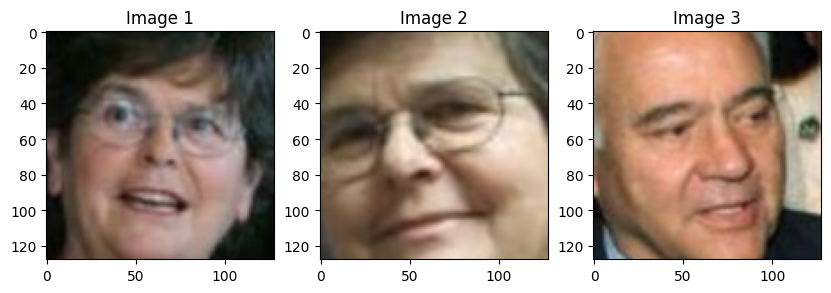

In [8]:
img1, img2, img3 = train_dataset.__getitem__(0)
print(img1.shape)
img1 = img1.permute(1,2,0)
img2 = img2.permute(1,2,0)
img3 = img3.permute(1,2,0)

fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

axes[0].imshow(img1)
axes[0].set_title('Image 1')  

axes[1].imshow(img2)
axes[1].set_title('Image 2')  

axes[2].imshow(img3)
axes[2].set_title('Image 3') 


plt.show()

In [9]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()

        self.resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights)
        out_fea = list(self.resnet.modules())[-1].out_features

        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_fea, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 2)
        )

    def forward_once(self, x):
        out = self.resnet(x)
        out = out.view(out.shape[0], -1)
        out = self.cls_head(out)
        return out

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        
        return output1, output2, output3

In [10]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin=3):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1) 
        distance_negative = (anchor - negative).pow(2).sum(1)  
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = SiameseNet()

criterion = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
def train(model, device, dataloader, optimizer, criterion):
    model.to(device)
    model.train()
    epoch_loss = 0 
    torch.manual_seed(42)
    
    for img1, img2, img3 in tqdm(dataloader, total=len(dataloader)):
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        optimizer.zero_grad()
        output1, output2, output3 = model(img1, img2, img3)
        loss = criterion(output1, output2, output3)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = epoch_loss / len(dataloader)
    return train_loss

In [13]:
def evaluate(model, device, dataloader):
    model.eval()
    
    images1 = []
    images2 = []
    images3 = []
    similarity_scores = []
    
    with torch.no_grad():
        img1, img2, img3 = valid_dataset[0]
        img1 = img1.reshape(1, 3, 128, 128)
        img2 = img2.reshape(1, 3, 128, 128)
        img3 = img3.reshape(1, 3, 128, 128)
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        output1, output2, output3 = model(img1, img2, img3) 
        
        #images1.append(img1)
        #images2.append(img2)
        #images3.append(img3)
        p_similarity = F.cosine_similarity(output1, output2, dim=1)
        n_similarity = F.cosine_similarity(output1, output3, dim=1)
        #similarity_scores.append((p_similarity.tolist(), n_similarity.tolist())) 

    return img1, img2, img3, p_similarity, n_similarity

In [14]:
epochs = 15
for epoch in range(1, epochs+ 1):
    loss = train(model, device, train_loader, optimizer, criterion)

    print(f"Epoch: {epoch}, Train los: {loss}\n")
torch.save(model.state_dict(), f"model_epoch_{epochs}.pth")

100%|██████████| 298/298 [00:15<00:00, 19.36it/s]


Epoch: 1, Train los: 2.6818459338989835



100%|██████████| 298/298 [00:17<00:00, 17.13it/s]


Epoch: 2, Train los: 1.4537065476179123



100%|██████████| 298/298 [00:12<00:00, 23.15it/s]


Epoch: 3, Train los: 0.7673241804110124



100%|██████████| 298/298 [00:12<00:00, 23.26it/s]


Epoch: 4, Train los: 0.4761934675426291



100%|██████████| 298/298 [00:12<00:00, 23.10it/s]


Epoch: 5, Train los: 0.3241337741781401



100%|██████████| 298/298 [00:12<00:00, 23.19it/s]


Epoch: 6, Train los: 0.2712868590082898



100%|██████████| 298/298 [00:12<00:00, 23.35it/s]


Epoch: 7, Train los: 0.23807940297078767



100%|██████████| 298/298 [00:12<00:00, 23.32it/s]


Epoch: 8, Train los: 0.18880397021370446



100%|██████████| 298/298 [00:12<00:00, 23.07it/s]


Epoch: 9, Train los: 0.19391624069453886



100%|██████████| 298/298 [00:12<00:00, 23.07it/s]


Epoch: 10, Train los: 0.22253985732993822



100%|██████████| 298/298 [00:12<00:00, 23.01it/s]


Epoch: 11, Train los: 0.251065493530075



100%|██████████| 298/298 [00:12<00:00, 23.06it/s]


Epoch: 12, Train los: 0.21989499832559753



100%|██████████| 298/298 [00:12<00:00, 23.21it/s]


Epoch: 13, Train los: 0.25969354198282996



100%|██████████| 298/298 [00:12<00:00, 22.97it/s]


Epoch: 14, Train los: 0.27888518451844285



100%|██████████| 298/298 [00:12<00:00, 23.29it/s]


Epoch: 15, Train los: 0.14323506084264526



In [15]:
chkpt_path = 'model_epoch_15.pth'
chkpt = torch.load(chkpt_path)
model.load_state_dict(chkpt)

<All keys matched successfully>

In [16]:
images1, images2, images3, p_scores, n_scores = evaluate(model, device, valid_loader)

In [17]:
def display_eval_results(images1, images2, images3, p_scores, n_scores):

    p_score = p_scores.cpu().numpy()
    n_score = n_scores.cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(images1[0].cpu().numpy().transpose(1,2,0))  
    plt.title("Image 1")

    plt.subplot(132)
    plt.imshow(images2[0].cpu().numpy().transpose(1,2,0))  
    plt.title("Image 2")

    plt.subplot(133)
    plt.imshow(images3[0].cpu().numpy().transpose(1,2,0))  
    plt.title("Image 3")

    plt.suptitle(f"Positive Score: {p_score[0]:.4f}, Negative Score: {n_score[0]:.4f}")
    plt.show()

torch.Size([3, 128, 128])


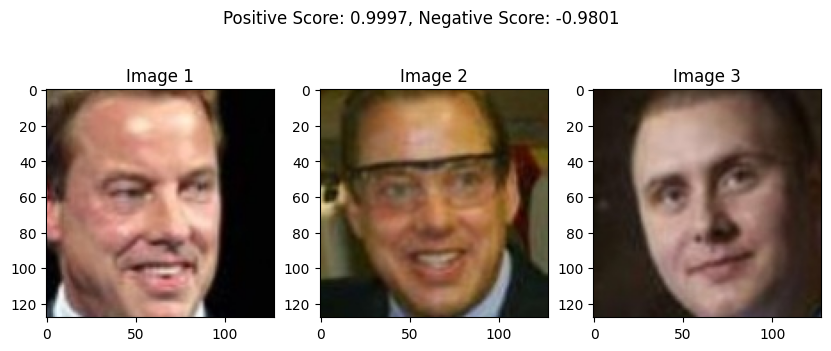

In [18]:
display_eval_results(images1, images2, images3, p_scores, n_scores)